<a href="https://colab.research.google.com/github/kaleetock/clusters/blob/main/Starter_Version_NGC457_Eclipsing_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs and Imports for Working with Images

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames	# XXX(tommy) remove?
from astropy.coordinates import Angle, Latitude, Longitude  # Angles	# XXX(tommy) remove?
import astropy.units as u	# XXX(tommy) remove?
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io.fits import PrimaryHDU, getdata, getheader	# XXX(tommy) remove?
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, ZScaleInterval, ImageNormalize	# XXX(tommy) remove?
from astropy.visualization.stretch import SquaredStretch	# XXX(tommy) remove?
!pip install sep
import numpy as np	# XXX(tommy) remove?
import sep
!pip install barycorrpy	# XXX(tommy) remove?
from astropy.time import Time	# XXX(tommy) remove?
from barycorrpy import utc_tdb	# XXX(tommy) remove?

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 885.7/885.7 KB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.4 MB/s eta 0:00:00


hjd,phase,V765Cas flux,comp1 flux,comp2 flux,file
2459898.5379999,0.5224140635227741,84968,84572,34869,2022-11-15T00_48_57_SI_exp120s_ASI183.fits
2459898.5395059,0.5232918029332723,84670,84693,35278,2022-11-15T00_51_07_SI_exp120s_ASI183.fits
2459898.5410128,0.5241700669610054,85193,84674,34308,2022-11-15T00_53_18_SI_exp120s_ASI183.fits
2459902.6724398,0.932082894649966,4256,4779,1711,2022-11-19T04_02_37_SI_exp120s_ASI183.fits
2459902.6739551,0.9329660544731269,7146,7511,2783,2022-11-19T04_04_48_SI_exp120s_ASI183.fits
2459902.6754655,0.9338463583478642,4204,4494,1686,2022-11-19T04_06_59_SI_exp120s_ASI183.fits
2459903.5274801,0.4304246312256055,78416,74860,30754,2022-11-20T00_33_54_SI_exp120s_ASI183.fits
2459903.5289963,0.43130831566622874,79835,76804,30952,2022-11-20T00_36_05_SI_exp120s_ASI183.fits
2459903.5305133,0.43219246637318065,78225,76670,31119,2022-11-20T00_38_16_SI_exp120s_ASI183.fits
2459904.5478359,0.025116930003605376,7484,9005,3658,2022-11-21T01_03_14_SI_exp120s_ASI183.fits

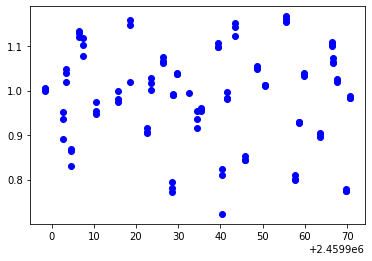

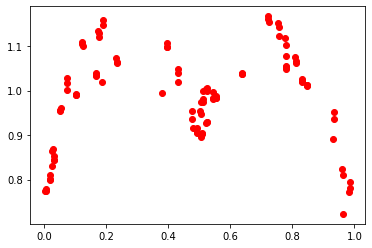

In [ ]:
##########################################################################

def measure_stars(imgpath, aperture, t_coord, c1_coord, c2_coord):

  stars = {"target": {"coord": t_coord, "flux": 0, "min_dist": 1000},
           "comp1": {"coord": c1_coord, "flux": 0, "min_dist": 1000},
           "comp2": {"coord": c2_coord, "flux": 0, "min_dist": 1000}}

  with fits.open(imgpath) as hdul:
    hdul.verify('fix')
    # XXX(tommy) data = hdul[0].data.astype(float)
    data = hdul[0].data
    hdr = hdul[0].header
    ins, hjd = hdr["INSTRUME"], hdr["HJD-OBS"]

    wrld = WCS(hdr)
    for name in stars:
      star = stars[name]
      y, x = wrld.world_to_array_index(star["coord"])    # get pixel coordinates of the star from the image plate solution
      star["x"] = x
      star["y"] = y

    # XXX(tommy) remove? (combine with declaration of data, see first 'XXX' in 'with' block)
    data = data.astype(float)   # get the number of photons that hit each pixel of the CCD as a 2D array
    bkg = sep.Background(data)  # (the following lines compute and subtract the sky background)
    bkg_image = bkg.back()	# XXX(tommy) remove?
    bkg_rms = bkg.rms()
    data_sub = data - bkg	# XXX(tommy) s/bkg/bkg_rms

    # find the objects (stars) in the image using source-extractor photometry and compute the flux of each

    objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)	# XXX 1.5 is the assumed "noise floor" of the images (above which the photons will be assumed to be coming from a star or other celestial object)
    # XXX(tommy) these vars aren't used.  where should they be used?
    flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                6.0, err=bkg.globalrms, gain=1.0)	# XXX(tommy) s/6.0/aperture

  # Loop through the objects in the image, noting if it is the closest so far
  # to one of the stars we are looking for (the target or the two comps).

  for i in range(len(objects)):
    x, y, flux = (objects['x'][i], objects['y'][i], objects['flux'][i])
    for name in stars:
      star = stars[name]
      sdist = (x-star["x"])**2 + (y-star["y"])**2
      if sdist < star["min_dist"]:
        star["min_dist"] = sdist
        star["flux"] = flux

  return(hjd, stars["target"]["flux"], stars["comp1"]["flux"], stars["comp2"]["flux"])

##########################################################################

import warnings
warnings.filterwarnings('ignore')

# VSX entry for target here: https://www.aavso.org/vsx/index.php?view=detail.top&oid=7096
# Comp111 and Check117 come from this VSP chart: https://app.aavso.org/vsp/chart/?ra=01%3A19%3A09.05&dec=58%3A17%3A26.0&scale=E&orientation=visual&type=chart&fov=30.0&maglimit=14.0&resolution=150&north=down&east=right
# Comp111 and Check117 coordinates from the photometry table (click on "Photometry Table" from the VSP link above)

p = "/content/drive/MyDrive/Orange Team/NGC_457_AAVSOnet/SI"  # Path to the SI images on Gdrive.
                                                              # Must change if the team folder name changes!

t_coord =  SkyCoord(19.78771, 58.2905, unit="deg")  # These coordinates come from the VSX and VSP links above     
c1_coord = SkyCoord(19.6243324, 58.183277, unit="deg")      # Here, "t" stands for "target", "c1" stands for "comp1", "c2" stands for "comp2"
c2_coord = SkyCoord(19.898874,58.375416, unit="deg")

aperture = 6.0       # measurement aperture to use (estimated by opening an image in AIJ and finding the target at 01:19:09.05 +58:17:26.0)
period = 1.715771    # period over which to fold (from VSX page above)
hjd0 = 2458066.914   # initial heliocentric julian date (also from VSX page)

hjds, phases, fluxes = [], [], []

print("hjd,phase,V765Cas flux,comp1 flux,comp2 flux,file")
files = [f for f in sorted(os.listdir(p)) if os.path.isfile(os.path.join(p,f))]
for f in files:
  imgpath = os.path.join(p,f)

  hjd, t_flux, c1_flux, c2_flux = measure_stars(imgpath, aperture, t_coord, c1_coord, c2_coord)
  phase = ((hjd-hjd0)/period)%1
  print(hjd, phase, round(t_flux), round(c1_flux), round(c2_flux), f, sep=',')

  hjds.append(hjd)
  phases.append(phase)             # fold the image dates over the known period
  fluxes.append(t_flux / c1_flux)  # compute flux as the ratio of the flux of the target to the first comp

plt.plot(hjds, fluxes, 'bo')    # Plot raw data (flux as a function of date) in blue
plt.figure()
plt.plot(phases, fluxes, 'ro')  # Plot the phased data (flux as a function of phase) in red